In [190]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [191]:
try:
    # Connect to an existing database
    connection = psycopg2.connect(database="2022-everything-team12", 
                            user='ycm3076', 
                            password='C13655814908y!', 
                            host='pg.analytics.northwestern.edu', 
                            port= '5432')

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
df = pd.read_sql("select * from \"aggtrnsact\"", connection);
if (connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed") 


You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 

PostgreSQL connection is closed


## Construct Dataset

In [192]:
# check the data
df.head()

,saledate,state,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,...,maxdiscount,totalprofit,avgprofittrnsact,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore
0,2004-08-01,AL,4016,4832,61,154686.64,1983.162051,0.0,650.0,112570.29,...,29.01,-11758.40,-150.749261,-275.0,103.75,12,10,56,411,34
1,2004-08-01,AR,2923,3692,46,124112.38,1571.042785,0.0,895.0,99210.52,...,65.01,-12614.80,-159.680887,-275.0,26.88,7,7,57,384,54
2,2004-08-01,AZ,6710,9272,83,282876.15,2548.433784,0.0,650.0,226252.94,...,75.01,-28469.10,-256.478568,-225.0,30.39,14,10,58,449,32
3,2004-08-01,CA,1054,1174,13,40297.12,457.921818,0.0,425.0,30868.73,...,32.50,-2904.78,-33.008864,-225.0,19.50,2,2,53,249,124
4,2004-08-01,CO,4062,5295,56,165998.81,1784.933441,0.0,895.0,122559.93,...,46.75,-14406.50,-154.908665,-275.0,44.75,11,9,58,381,34


In [193]:
df.columns

Index(['saledate', 'state', 'nsku', 'totalquantity', 'avgquantity', 'totalamt',
       'avgamt', 'minamt', 'maxamt', 'totalorigprice', 'avgorigprice',
       'minorigprice', 'maxorigprice', 'totalretail', 'avgretail', 'minretail',
       'maxretail', 'avgretailtrnsact', 'totalcost', 'avgcost', 'mincost',
       'maxcost', 'avgcosttrnsact', 'totaldiscount', 'avgdiscounttrnsact',
       'mindiscount', 'maxdiscount', 'totalprofit', 'avgprofittrnsact',
       'minprofit', 'maxprofit', 'nstore', 'ncities', 'ndept', 'nvendors',
       'avgvendorsstore'],
      dtype='object')

In [194]:
# check null value counts
df.notnull().sum()

saledate              11281
state                 11281
nsku                  11281
totalquantity         11281
avgquantity           11281
totalamt              11281
avgamt                11281
minamt                11281
maxamt                11281
totalorigprice        11281
avgorigprice          11281
minorigprice          11281
maxorigprice          11281
totalretail           11281
avgretail             11281
minretail             11281
maxretail             11281
avgretailtrnsact      11281
totalcost             11281
avgcost               11281
mincost               11281
maxcost               11281
avgcosttrnsact        11281
totaldiscount         11281
avgdiscounttrnsact    11281
mindiscount           11281
maxdiscount           11281
totalprofit           11281
avgprofittrnsact      11281
minprofit             11281
maxprofit             11281
nstore                11281
ncities               11281
ndept                 11281
nvendors              11281
avgvendorsstore     

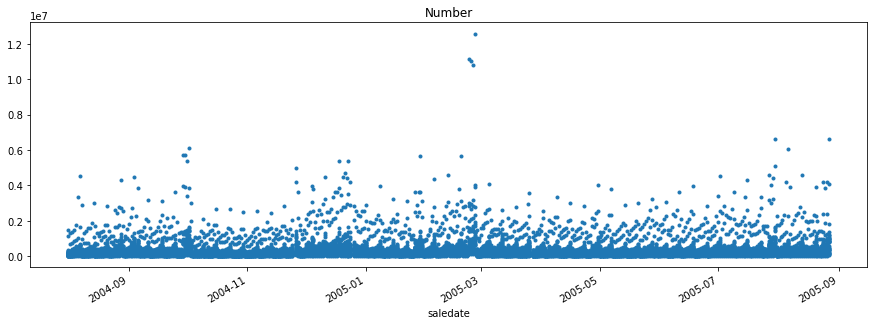

In [195]:
df_groupyed = df
color_pal = sns.color_palette()
# set df index as date
df_ts = df_groupyed.set_index('saledate')
df_ts.index = pd.to_datetime(df_ts.index)
# check distribution of amount (no pattern found)
df_ts_draw = df_ts["totalamt"]
df_ts_draw.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Number')
plt.show()

In [196]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    return df
# create time series features
df_ts = create_features(df_ts)
df_ts

,state,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,avgorigprice,...,nstore,ncities,ndept,nvendors,avgvendorsstore,dayofweek,quarter,month,year,dayofmonth
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,AL,4016,4832,61,154686.64,1983.162051,0.0,650.0,112570.29,23.296832,...,12,10,56,411,34,6,3,8,2004,1
2004-08-01,AR,2923,3692,46,124112.38,1571.042785,0.0,895.0,99210.52,26.871755,...,7,7,57,384,54,6,3,8,2004,1
2004-08-01,AZ,6710,9272,83,282876.15,2548.433784,0.0,650.0,226252.94,24.401741,...,14,10,58,449,32,6,3,8,2004,1
2004-08-01,CA,1054,1174,13,40297.12,457.921818,0.0,425.0,30868.73,26.293637,...,2,2,53,249,124,6,3,8,2004,1
2004-08-01,CO,4062,5295,56,165998.81,1784.933441,0.0,895.0,122559.93,23.146351,...,11,9,58,381,34,6,3,8,2004,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-27,TN,19319,28464,121,1204982.36,5127.584511,0.0,788.0,578953.01,20.339833,...,14,10,60,586,41,5,3,8,2005,27
2005-08-27,TX,62545,156933,458,6627749.79,19379.385351,0.0,1200.0,3189055.04,20.321125,...,57,46,60,802,14,5,3,8,2005,27
2005-08-27,UT,8985,12166,76,422610.82,2657.929686,0.0,695.0,220702.78,18.140949,...,6,6,56,467,77,5,3,8,2005,27


In [198]:
orignal_features = list(df.columns)
orignal_features.remove('saledate')
orignal_features.remove('state')
orignal_features

['nsku',
 'totalquantity',
 'avgquantity',
 'totalamt',
 'avgamt',
 'minamt',
 'maxamt',
 'totalorigprice',
 'avgorigprice',
 'minorigprice',
 'maxorigprice',
 'totalretail',
 'avgretail',
 'minretail',
 'maxretail',
 'avgretailtrnsact',
 'totalcost',
 'avgcost',
 'mincost',
 'maxcost',
 'avgcosttrnsact',
 'totaldiscount',
 'avgdiscounttrnsact',
 'mindiscount',
 'maxdiscount',
 'totalprofit',
 'avgprofittrnsact',
 'minprofit',
 'maxprofit',
 'nstore',
 'ncities',
 'ndept',
 'nvendors',
 'avgvendorsstore']

In [199]:
# TODO: add lags
def create_lag_feature(df, column):
    '''
    Create time lagging features
    '''
    df = df.copy()
    average_value = np.mean(df[column])
    df[column + '_1'] = df[column].shift(1,fill_value = average_value)
    df[column + '_2'] = df[column].shift(2,fill_value = average_value)
    df[column + '_3'] = df[column].shift(3,fill_value = average_value)
    df[column + '_4'] = df[column].shift(4,fill_value = average_value)
    df[column + '_5'] = df[column].shift(5,fill_value = average_value)
    df[column + '_6'] = df[column].shift(6,fill_value = average_value)
    df[column + '_7'] = df[column].shift(7,fill_value = average_value)
    df[column + '_14'] = df[column].shift(14,fill_value = average_value)
    df[column + '_28'] = df[column].shift(28,fill_value = average_value)
    return df

df_model = pd.DataFrame(columns = df_ts.columns)
for state in df_ts['state'].drop_duplicates().tolist():
    df_part = df_ts[df_ts['state']==state]
    for col in orignal_features:
        df_part = create_lag_feature(df_part, col)
    df_model = df_model.append(df_part)

orignal_features1 = orignal_features.copy()
orignal_features1.remove('totalamt')
df_ts_lagged = df_model.drop(orignal_features1, axis=1)
df_ts_lagged

,state,totalamt,dayofweek,quarter,month,year,dayofmonth,nsku_1,nsku_2,nsku_3,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
2004-08-01,AL,154686.64,6,3,8,2004,1,6902.113111,6902.113111,6902.113111,...,463.796915,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-02,AL,177630.18,0,3,8,2004,2,4016.000000,6902.113111,6902.113111,...,463.796915,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-03,AL,203399.34,1,3,8,2004,3,4539.000000,4016.000000,6902.113111,...,463.796915,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-04,AL,199944.96,2,3,8,2004,4,5165.000000,4539.000000,4016.000000,...,463.796915,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-05,AL,213268.97,3,3,8,2004,5,5008.000000,5165.000000,4539.000000,...,463.796915,37.000000,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,WY,12950.74,1,3,8,2005,23,432.000000,478.000000,777.000000,...,158.000000,154.000000,161.000000,201.000000,179.000000,162.000000,163.000000,158.000000,140.000000,158.000000
2005-08-24,WY,31830.29,2,3,8,2005,24,453.000000,432.000000,478.000000,...,214.000000,146.000000,154.000000,161.000000,201.000000,179.000000,162.000000,163.000000,144.000000,214.000000
2005-08-25,WY,30399.62,3,3,8,2005,25,917.000000,453.000000,432.000000,...,242.000000,216.000000,146.000000,154.000000,161.000000,201.000000,179.000000,162.000000,171.000000,242.000000
2005-08-26,WY,36792.64,4,3,8,2005,26,841.000000,917.000000,453.000000,...,208.000000,199.000000,216.000000,146.000000,154.000000,161.000000,201.000000,179.000000,171.000000,208.000000


In [200]:
df_ts_lagged.columns

Index(['state', 'totalamt', 'dayofweek', 'quarter', 'month', 'year',
       'dayofmonth', 'nsku_1', 'nsku_2', 'nsku_3',
       ...
       'nvendors_28', 'avgvendorsstore_1', 'avgvendorsstore_2',
       'avgvendorsstore_3', 'avgvendorsstore_4', 'avgvendorsstore_5',
       'avgvendorsstore_6', 'avgvendorsstore_7', 'avgvendorsstore_14',
       'avgvendorsstore_28'],
      dtype='object', length=313)

## Prophet Modeling

In [248]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
import itertools

In [202]:
df_total = df_ts_lagged.copy()
df_total

,state,totalamt,dayofweek,quarter,month,year,dayofmonth,nsku_1,nsku_2,nsku_3,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
2004-08-01,AL,154686.64,6,3,8,2004,1,6902.113111,6902.113111,6902.113111,...,463.796915,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-02,AL,177630.18,0,3,8,2004,2,4016.000000,6902.113111,6902.113111,...,463.796915,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-03,AL,203399.34,1,3,8,2004,3,4539.000000,4016.000000,6902.113111,...,463.796915,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-04,AL,199944.96,2,3,8,2004,4,5165.000000,4539.000000,4016.000000,...,463.796915,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2004-08-05,AL,213268.97,3,3,8,2004,5,5008.000000,5165.000000,4539.000000,...,463.796915,37.000000,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,WY,12950.74,1,3,8,2005,23,432.000000,478.000000,777.000000,...,158.000000,154.000000,161.000000,201.000000,179.000000,162.000000,163.000000,158.000000,140.000000,158.000000
2005-08-24,WY,31830.29,2,3,8,2005,24,453.000000,432.000000,478.000000,...,214.000000,146.000000,154.000000,161.000000,201.000000,179.000000,162.000000,163.000000,144.000000,214.000000
2005-08-25,WY,30399.62,3,3,8,2005,25,917.000000,453.000000,432.000000,...,242.000000,216.000000,146.000000,154.000000,161.000000,201.000000,179.000000,162.000000,171.000000,242.000000
2005-08-26,WY,36792.64,4,3,8,2005,26,841.000000,917.000000,453.000000,...,208.000000,199.000000,216.000000,146.000000,154.000000,161.000000,201.000000,179.000000,171.000000,208.000000


In [30]:
for state in df_total['state'].drop_duplicates().tolist():
    print(state, end = " ")
    df_state = df_total[df_total['state']==state]
    df_ts = pd.DataFrame({'ds':df_state.index,'y':df_state.totalamt})
    df_ts

AL AR AZ CA CO FL GA IA ID IL IN KS KY LA MO MS MT NC NE NM NV OH OK SC TN TX UT VA WY 

### Dataset Construction

In [204]:
df_state = df_total[df_total['state']=='AL']
df_state = df_state.reset_index()
df_state = df_state.rename(columns = {'index':'ds','totalamt':'y'})
df_state = df_state.drop(columns = ['state'])
df_state

,ds,y,dayofweek,quarter,month,year,dayofmonth,nsku_1,nsku_2,nsku_3,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
0,2004-08-01,154686.64,6,3,8,2004,1,6902.113111,6902.113111,6902.113111,...,463.796915,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
1,2004-08-02,177630.18,0,3,8,2004,2,4016.000000,6902.113111,6902.113111,...,463.796915,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
2,2004-08-03,203399.34,1,3,8,2004,3,4539.000000,4016.000000,6902.113111,...,463.796915,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
3,2004-08-04,199944.96,2,3,8,2004,4,5165.000000,4539.000000,4016.000000,...,463.796915,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478,38.326478
4,2004-08-05,213268.97,3,3,8,2004,5,5008.000000,5165.000000,4539.000000,...,463.796915,37.000000,36.000000,35.000000,34.000000,38.326478,38.326478,38.326478,38.326478,38.326478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2005-08-23,233697.92,1,3,8,2005,23,4611.000000,5130.000000,10994.000000,...,468.000000,37.000000,38.000000,44.000000,41.000000,39.000000,39.000000,39.000000,39.000000,39.000000
385,2005-08-24,633511.33,2,3,8,2005,24,5154.000000,4611.000000,5130.000000,...,564.000000,37.000000,37.000000,38.000000,44.000000,41.000000,39.000000,39.000000,39.000000,47.000000
386,2005-08-25,576269.54,3,3,8,2005,25,11641.000000,5154.000000,4611.000000,...,541.000000,46.000000,37.000000,37.000000,38.000000,44.000000,41.000000,39.000000,42.000000,45.000000
387,2005-08-26,647460.36,4,3,8,2005,26,10813.000000,11641.000000,5154.000000,...,559.000000,43.000000,46.000000,37.000000,37.000000,38.000000,44.000000,41.000000,42.000000,46.000000


### train/test split

In [205]:
df_train = df_state[df_state['ds']<='2005-05-31']
df_test = df_state[df_state['ds']>'2005-05-31']

In [206]:
df_train.columns

Index(['ds', 'y', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth',
       'nsku_1', 'nsku_2', 'nsku_3',
       ...
       'nvendors_28', 'avgvendorsstore_1', 'avgvendorsstore_2',
       'avgvendorsstore_3', 'avgvendorsstore_4', 'avgvendorsstore_5',
       'avgvendorsstore_6', 'avgvendorsstore_7', 'avgvendorsstore_14',
       'avgvendorsstore_28'],
      dtype='object', length=313)

### Adding holidays, seasonality and additional features

In [207]:
orignal_features

['nsku',
 'totalquantity',
 'avgquantity',
 'totalamt',
 'avgamt',
 'minamt',
 'maxamt',
 'totalorigprice',
 'avgorigprice',
 'minorigprice',
 'maxorigprice',
 'totalretail',
 'avgretail',
 'minretail',
 'maxretail',
 'avgretailtrnsact',
 'totalcost',
 'avgcost',
 'mincost',
 'maxcost',
 'avgcosttrnsact',
 'totaldiscount',
 'avgdiscounttrnsact',
 'mindiscount',
 'maxdiscount',
 'totalprofit',
 'avgprofittrnsact',
 'minprofit',
 'maxprofit',
 'nstore',
 'ncities',
 'ndept',
 'nvendors',
 'avgvendorsstore']

In [307]:
dict_param = {  
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 10.0,
    'holidays_prior_scale': 10.0
}

def modeling(df_train,dict_param):
    
    #add seasonality
    '''
        We drop the yearly seasonality since the training dataset is less than one year and we add quarterly, montly seasonality instead.
    '''
    m = Prophet(yearly_seasonality = False,growth = 'flat',**dict_param)
    #m.add_seasonality(name="quarterly", period=90, fourier_order = 10)
    m.add_seasonality(name='monthly', period=30, fourier_order=5) 

    #add holiday
    m.add_country_holidays(country_name='US')

    #add additional features
    feature_list = ['nsku',
                    'avgdiscounttrnsact',
                    'nstore',
                    'ncities',
                    'ndept',
                    'nvendors',
                    'avgvendorsstore']
    for feature in feature_list:
        m.add_regressor(feature+'_1',standardize = "auto")

    m.fit(df_train)
    
    return m

m = modeling(df_train,dict_param)

17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
#check the influence of regressors to y
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,nsku_1,additive,6806.754529,29.949286,29.949286,29.949286
1,avgdiscounttrnsact_1,additive,-173.887636,25.642319,25.642319,25.642319
2,nstore_1,additive,11.956665,-371063.431699,-371063.431699,-371063.431699
3,ncities_1,additive,9.959996,419861.021723,419861.021723,419861.021723
4,ndept_1,additive,56.184398,-7709.308258,-7709.308258,-7709.308258
5,nvendors_1,additive,459.770089,499.925086,499.925086,499.925086
6,avgvendorsstore_1,additive,37.977829,4801.268823,4801.268823,4801.268823


### Model tuning

In [309]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store the RMSEs for each params here
mse = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = modeling(df_train,params) # Fit model with given params
    df_cv = cross_validation(m, initial = '200 days',period = '15 days',horizon = '15 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mse.append(df_p['mse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mse
print(tuning_results)
best_params = all_params[np.argmin(mse)]

17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:08 - cmdstanpy - INFO - Chain [1] done processing
17:48:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:08 - cmdstanpy - INFO - Chain [1] done processing
17:48:08 - cmdstanpy - INFO - Chain [1] start processing
17:48:08 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing
17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing
17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing
17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:15 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:15 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing
17:48:15 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:17 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:17 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1] done processing
17:48:17 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1] done processing
17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
17:48:21 - cmdstanpy - INFO - Chain [1] done processing
17:48:22 - cmdstanpy - INFO - Chain [1] start processing
17:48:22 - cmdstanpy - INFO - Chain [1] done processing
17:48:22 - cmdstanpy - INFO - Chain [1] start processing
17:48:22 - cmdstanpy - INFO - Chain [1] done processing
17:48:22 - cmdstanpy - INFO - Chain [1] start processing
17:48:22 - cmdstanpy - INFO - Chain [1] done processing
17:48:23 - cmdstanpy - INFO - Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing
17:48:23 - cmdstanpy - INFO - Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:23 - cmdstanpy - INFO - Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing
17:48:23 - cmdstanpy - INFO - Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1] done processing
17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1] done processing
17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1] done processing
17:48:28 - cmdstanpy - INFO - Chain [1] start processing
17:48:28 - cmdstanpy - INFO - Chain [1] done processing
17:48:28 - cmdstanpy - INFO - Chain [1] start processing
17:48:28 - cmdstanpy - INFO - Chain [1] done processing
17:48:28 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing
17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing
17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing
17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing
17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing
17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing
17:48:38 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing
17:48:38 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing
17:48:38 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:44 - cmdstanpy - INFO - Chain [1] done processing
17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:44 - cmdstanpy - INFO - Chain [1] done processing
17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:44 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
17:48:47 - cmdstanpy - INFO - Chain [1] start processing
17:48:47 - cmdstanpy - INFO - Chain [1] done processing
17:48:47 - cmdstanpy - INFO - Chain [1] start processing
17:48:47 - cmdstanpy - INFO - Chain [1] done processing
17:48:47 - cmdstanpy - INFO - Chain [1] start processing
17:48:47 - cmdstanpy - INFO - Chain [1] done processing
17:48:48 - cmdstanpy - INFO - Chain [1] start processing
17:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:48 - cmdstanpy - INFO - Chain [1] start processing
17:48:48 - cmdstanpy - INFO - Chain [1] done processing
17:48:48 - cmdstanpy - INFO - Chain [1] start processing
17:48:48 - cmdstanpy - INFO - Chain [1] done processing
17:48:48 - cmdstanpy - INFO - Chain [1] start processing
17:48:48 - cmdstanpy - INFO - Chain [1] done processing
17:48:49 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing
17:48:49 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing
17:48:49 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing
17:48:53 - cmdstanpy - INFO - Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing
17:48:53 - cmdstanpy - INFO - Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing
17:48:53 - cmdstanpy - INFO - Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing
17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing
17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing
17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
17:48:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:01 - cmdstanpy - INFO - Chain [1] start processing
17:49:01 - cmdstanpy - INFO - Chain [1] done processing
17:49:01 - cmdstanpy - INFO - Chain [1] start processing
17:49:01 - cmdstanpy - INFO - Chain [1] done processing
17:49:01 - cmdstanpy - INFO - Chain [1] start processing
17:49:01 - cmdstanpy - INFO - Chain [1] done processing
17:49:02 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:02 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:02 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:02 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing
17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing
17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing
17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing
17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing
17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing
17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
17:49:17 - cmdstanpy - INFO - Chain [1] start processing
17:49:17 - cmdstanpy - INFO - Chain [1] done processing
17:49:17 - cmdstanpy - INFO - Chain [1] start processing
17:49:17 - cmdstanpy - INFO - Chain [1] done processing
17:49:17 - cmdstanpy - INFO - Chain [1] start processing
17:49:17 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1] done processing
17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing
17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing
17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing
17:49:28 - cmdstanpy - INFO - Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing
17:49:28 - cmdstanpy - INFO - Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing
17:49:28 - cmdstanpy - INFO - Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:31 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:31 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing
17:49:31 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing
17:49:31 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1] done processing
17:49:32 - cmdstanpy - INFO - Chain [1] start processing
17:49:32 - cmdstanpy - INFO - Chain [1] done processing
17:49:32 - cmdstanpy - INFO - Chain [1] start processing
17:49:32 - cmdstanpy - INFO - Chain [1] done processing
17:49:32 - cmdstanpy - INFO - Chain [1] start processing
17:49:32 - cmdstanpy - INFO - Chain [1] done processing
17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:36 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing
17:49:36 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing
17:49:36 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing
17:49:37 - cmdstanpy - INFO - Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:37 - cmdstanpy - INFO - Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing
17:49:37 - cmdstanpy - INFO - Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing
17:49:37 - cmdstanpy - INFO - Chain [1] start processing
17:49:38 - cmdstanpy - INFO - Chain [1] done processing
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:38 - cmdstanpy - INFO - Chain [1] done processing
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:38 - cmdstanpy - INFO - Chain [1] done processing
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:38 - cmdstanpy - INFO - Chain [1] done processing
17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:40 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:40 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:40 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:42 - cmdstanpy - INFO - Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing
17:49:42 - cmdstanpy - INFO - Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing
17:49:42 - cmdstanpy - INFO - Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing
17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing
17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing
17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing
17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing
17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing
17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing
17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing
17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:56 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:49:56 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:49:56 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

17:49:57 - cmdstanpy - INFO - Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
17:49:58 - cmdstanpy - INFO - Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing
17:49:58 - cmdstanpy - INFO - Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing
17:49:58 - cmdstanpy - INFO - Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing
17:49:59 - cmdstanpy - INFO - Chain [1] start processing
17:49:59 - cmdstanpy - INFO - Chain [1] done processing
17:49:59 - cmdstanpy - INFO - Chain [1] start processing
17:49:59 - cmdstanpy - INFO - Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                  0.01   
1                     0.001                     0.01                  0.10   
2                     0.001                     0.01                  1.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.10   
62                    0.500                    10.00                  1.00   
63                    0.500                    10.00                 10.00   

             mse  
0   8.243614e+09  
1   8.606435e+09  
2   8.

In [310]:
best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.1,
 'holidays_prior_scale': 0.01}

In [311]:
#rebuild the model with best_params
m = modeling(df_train,best_params)

18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:51 - cmdstanpy - INFO - Chain [1] done processing


In [312]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,nsku_1,additive,6806.754529,16.589340,16.589340,16.589340
1,avgdiscounttrnsact_1,additive,-173.887636,25.500418,25.500418,25.500418
2,nstore_1,additive,11.956665,227.519892,227.519892,227.519892
3,ncities_1,additive,9.959996,7957.397673,7957.397673,7957.397673
4,ndept_1,additive,56.184398,-8269.330096,-8269.330096,-8269.330096
5,nvendors_1,additive,459.770089,663.999911,663.999911,663.999911
6,avgvendorsstore_1,additive,37.977829,8349.258298,8349.258298,8349.258298


### Model Prediction

In [313]:
#model prediction
df_future = df_state.copy()
future = df_future.drop(columns = 'y')
forecast = m.predict(future)
df_result = forecast[['ds','yhat']]
df_result['y'] = df_state['y'].tolist()
df_result

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ds,yhat,y
0,2004-08-01,121770.789108,154686.64
1,2004-08-02,195781.080623,177630.18
2,2004-08-03,218220.637525,203399.34
3,2004-08-04,299602.299941,199944.96
4,2004-08-05,290370.415707,213268.97
...,...,...,...
384,2005-08-23,313672.266476,233697.92
385,2005-08-24,357181.460415,633511.33
386,2005-08-25,594326.930475,576269.54
387,2005-08-26,574280.523546,647460.36


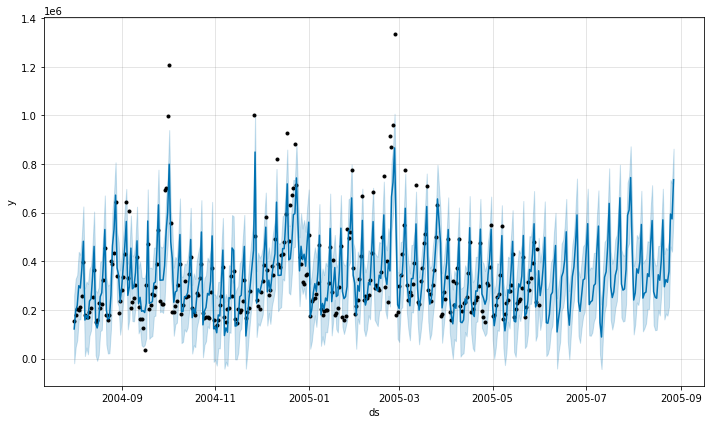

In [314]:
future = df_state.drop(columns = 'y')
forecast = m.predict(future)
fig1 = m.plot(forecast)

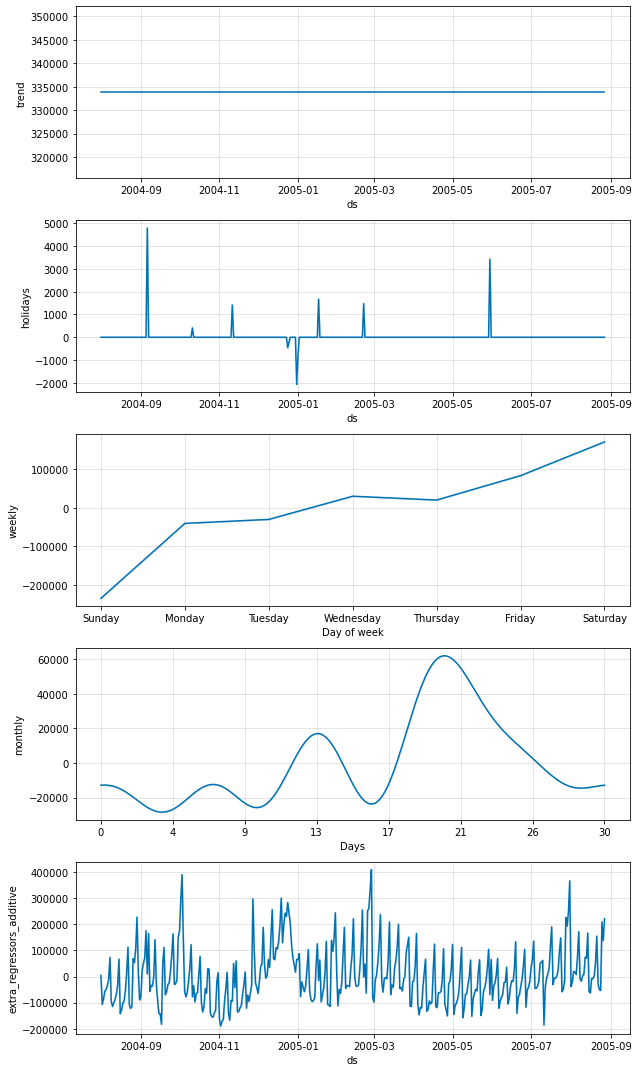

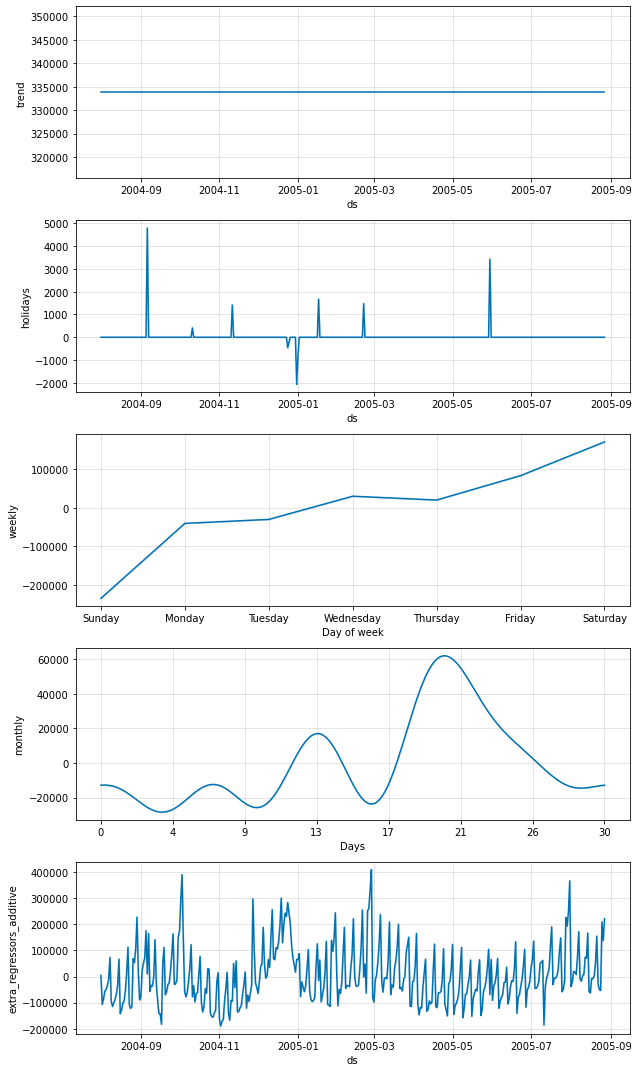

In [315]:
fig = m.plot_components(forecast)
fig

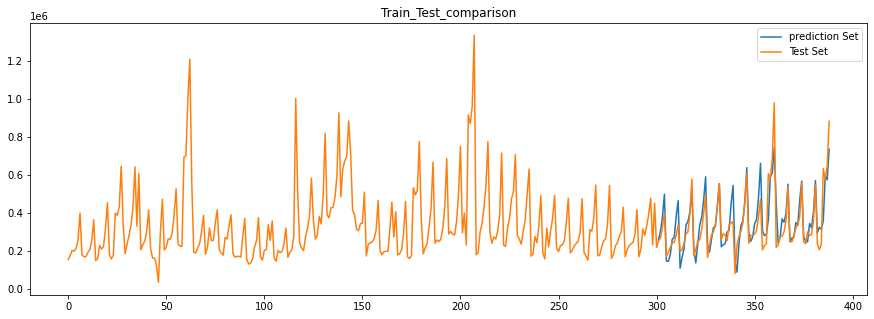

In [316]:
# graph the distribution of prediction vs actual
test_ts_draw = df_result['y']
test_prediction = df_result[df_result['ds']>='2005-06-01']['yhat']
fig, ax = plt.subplots(figsize=(15, 5))
test_prediction.plot(ax=ax, label='prediction Set', title='Train_Test_comparison')
test_ts_draw.plot(ax=ax, label='Test Set')
ax.legend(['prediction Set', 'Test Set'])
plt.show()

In [317]:
df_result[df_result['ds']>='2005-06-01']

,ds,yhat,y
301,2005-06-01,259057.673238,252582.92
302,2005-06-02,304209.858380,269173.14
303,2005-06-03,380360.560113,327236.06
304,2005-06-04,498768.209551,398969.14
305,2005-06-05,147481.061545,170574.17
...,...,...,...
384,2005-08-23,313672.266476,233697.92
385,2005-08-24,357181.460415,633511.33
386,2005-08-25,594326.930475,576269.54
387,2005-08-26,574280.523546,647460.36


In [318]:
import sklearn.metrics as metrics
def show_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [319]:
show_results(df_result[df_result['ds']>='2005-06-01']['y'],df_result[df_result['ds']>='2005-06-01']['yhat'])

explained_variance:  0.7281
r2:  0.72
MAE:  59379.3818
MSE:  6742974085.5723
RMSE:  82115.6141
